<a href="https://colab.research.google.com/github/taggartpatrick/basic_bike_sales_analytics/blob/main/Bike_Sales_Customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load libraries


In [ ]:
# Load basic libraries
import pandas as pd
import numpy as np
import altair as alt
import datetime as dt

In [ ]:
# load pandas profiling 
import sys

!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

import pandas_profiling

Requirement already up-to-date: pandas-profiling[notebook] in /usr/local/lib/python3.6/dist-packages (2.9.0)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
# load interactive tables
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
# load plotly 
!pip install -q plotly==4.2.1
import plotly.graph_objects as go

from IPython.display import HTML
import plotly.express as px

In [ ]:
# load seaborn libraries 
import seaborn as sns
import matplotlib.pyplot as plt 

### Import data


#### Import data from Gitbuh repo

In [ ]:
# Clone Github directory
!git clone https://github.com/taggartpatrick/basic_bike_sales_analytics
!ls

Cloning into 'basic_bike_sales_analytics'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.
basic_analytics  basic_bike_sales_analytics  sample_data


In [ ]:
# Import ordeline data 
orderlines = pd.read_excel("/content/basic_bike_sales_analytics/orderlines.xlsx")

# Import bikeshop data 
bikeshops = pd.read_excel("/content/basic_bike_sales_analytics/bikeshops.xlsx")

# Import bike data 
bikes = pd.read_excel("/content/basic_bike_sales_analytics/bikes.xlsx")

In [ ]:
# Import bike orderline data 
bike_orderlines = pd.read_csv("/content/basic_bike_sales_analytics/bike_orderlines.csv")

### Tidy and Transform Bike Sales Data

#### Combine Excel Files into one dataframe

In [ ]:
# Rename key fields in relevant excel based dataframes for merging

bikes = bikes.rename(columns = {'bike.id':'product.id'})
bikeshops = bikeshops.rename(columns = {'bikeshop.id': 'customer.id'})

# Join dataframes into one overall dataframe

bike_order_data = pd.merge(orderlines,bikes, on = 'product.id')
bike_order_data = pd.merge(bike_order_data,bikeshops, on = 'customer.id')

#### Tidy Dataframe

In [ ]:
# Rename key fields
bike_sales_tbl = bike_order_data.rename(columns = {
    'order.date' : 'order_date',
    'order.id' : 'order_id',
    'order.line' : 'order_line',
    'bikeshop.name':'bikeshop_name'
    })

# Drop uneeded fields 
bike_sales_tbl = bike_sales_tbl.drop(['Unnamed: 0','customer.id','product.id'], axis = 1) 

# Split location fields and split decsription fields 
bike_sales_tbl[['major_category','minor_category','frame_material']] = bike_sales_tbl['description'].str.split(' - ',2,expand = True)

# Add fields for month, day and year

def get_ym(x): return dt.datetime(x.year,x.month,1)

bike_sales_tbl['order_month'] = pd.DatetimeIndex(bike_sales_tbl['order_date']).month
bike_sales_tbl['order_day'] = pd.DatetimeIndex(bike_sales_tbl['order_date']).day
bike_sales_tbl['order_year'] = pd.DatetimeIndex(bike_sales_tbl['order_date']).year
bike_sales_tbl['order_ym'] = bike_sales_tbl['order_date'].apply(get_ym)
bike_sales_tbl['order_weekday'] = pd.to_datetime(bike_sales_tbl['order_date']).dt.day_name()

# Add total sales value 
bike_sales_tbl['sales_value'] = bike_sales_tbl['price']*bike_sales_tbl['quantity']


### Perform Basic customer segment analysis

#### Analyse customer cohorts

Customer cohort anlaysis looks at two things: 
1. When a customer made their first purchase 
2. How many months a customer was active after that first purchase

If individual customer purchase trends are aggregated, you can easily get a view of the number of active customers monthly relative to when they made their first purchase 

If this number remains high it means customers are loyal 


Step 1: Get Cohort count matrix

In [ ]:
# Filter sales table to see data for a specific year 

filter_years = ['2012']

cust_sales_tbl = bike_sales_tbl[bike_sales_tbl['order_year'].isin(filter_years)]

In [ ]:
# Get date of first purchase month by customer 
grouping = cust_sales_tbl.groupby(['bikeshop_name'])['order_ym']
cust_sales_tbl['cohort_ym'] = grouping.transform('min')

# Get Month's offset from initial purchase 
def get_date_int (df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

order_year,order_month,_ = get_date_int(cust_sales_tbl,'order_ym')
cohort_year,cohort_month,_ = get_date_int(cust_sales_tbl,'cohort_ym')
years_diff = order_year - cohort_year
months_diff = order_month - cohort_month

cust_sales_tbl['cohort_index'] = years_diff*12 + months_diff + 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
cust_sales_tbl.head()

,order_id,order_line,order_date,quantity,model,description,price,bikeshop_name,location,major_category,minor_category,frame_material,order_month,order_day,order_year,order_ym,order_weekday,sales_value,cohort_ym,cohort_index
2,507,2,2012-06-26,1,Jekyll Carbon 2,Mountain - Over Mountain - Carbon,6070,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,6,26,2012,2012-06-01,Tuesday,6070,2012-03-01,4
3,528,18,2012-07-16,1,Jekyll Carbon 2,Mountain - Over Mountain - Carbon,6070,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,7,16,2012,2012-07-01,Monday,6070,2012-03-01,5
21,460,2,2012-05-08,1,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,5,8,2012,2012-05-01,Tuesday,5970,2012-03-01,3
22,479,5,2012-06-06,1,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,6,6,2012,2012-06-01,Wednesday,5970,2012-03-01,4
23,507,9,2012-06-26,1,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,6,26,2012,2012-06-01,Tuesday,5970,2012-03-01,4


In [ ]:
# Count No of monthly active customers from each cohort 

grouping = cust_sales_tbl.groupby(['cohort_ym','cohort_index'])
cohort_data = grouping['bikeshop_name'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index = 'cohort_ym',columns = 'cohort_index',values = 'bikeshop_name')

print(cohort_counts)

cohort_index    1    2    3    4    5    6    7    8    9    10   11   12
cohort_ym                                                                
2012-01-01    11.0  8.0  8.0  9.0  5.0  8.0  8.0  5.0  6.0  7.0  8.0  8.0
2012-02-01     9.0  6.0  7.0  4.0  2.0  3.0  6.0  3.0  4.0  3.0  1.0  NaN
2012-03-01     7.0  4.0  2.0  3.0  2.0  4.0  4.0  2.0  3.0  1.0  NaN  NaN
2012-06-01     2.0  2.0  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2012-07-01     1.0  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN


Step 2: Calculate cohort metrics

Calculate retention rate (%)

In [ ]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis = 0).round(3)
retention = retention.reset_index()
retention

cohort_index,cohort_ym,1,2,3,4,5,6,7,8,9,10,11,12
0,2012-01-01,1.0,0.727,0.727,0.818,0.455,0.727,0.727,0.455,0.545,0.636,0.727,0.727
1,2012-02-01,1.0,0.667,0.778,0.444,0.222,0.333,0.667,0.333,0.444,0.333,0.111,NaN
2,2012-03-01,1.0,0.571,0.286,0.429,0.286,0.571,0.571,0.286,0.429,0.143,NaN,NaN
3,2012-06-01,1.0,1.000,0.500,0.500,0.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-07-01,1.0,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Show heatmap active customer matrix


In [ ]:
base = alt.Chart(cohort_data).encode(
    alt.X('cohort_index:O', scale=alt.Scale(paddingInner=0)),
    alt.Y('cohort_ym:O', scale=alt.Scale(paddingInner=0)),
).properties(width=600, height=200)

heatmap = base.mark_rect().encode(
    color = alt.Color('bikeshop_name',scale=alt.Scale(scheme='blues'))
)
text = base.mark_text(baseline = 'middle').encode(
    text = 'bikeshop_name:Q',
    color = alt.condition(
        alt.datum.bikeshop_name > 7,
        alt.value('white'),
        alt.value('black')
        )
)
    
heatmap + text

alt.LayerChart(...)

Show heatmap customer retention rate (%) matrix

In [ ]:
# Convert retention matrix from wide to long
retention_data = pd.melt(retention, id_vars = ['cohort_ym'],value_name = 'retention_pct')
retention_data.head(25)

,cohort_ym,cohort_index,retention_pct
0,2012-01-01,1,1.000
1,2012-02-01,1,1.000
2,2012-03-01,1,1.000
3,2012-06-01,1,1.000
4,2012-07-01,1,1.000
5,2012-01-01,2,0.727
6,2012-02-01,2,0.667
7,2012-03-01,2,0.571
8,2012-06-01,2,1.000
9,2012-07-01,2,NaN


In [ ]:
base = alt.Chart(retention_data).encode(
    alt.X('cohort_index:O', scale=alt.Scale(paddingInner=0)),
    alt.Y('cohort_ym:O', scale=alt.Scale(paddingInner=0)),
).properties(width=600, height=200)

heatmap = base.mark_rect().encode(
    color = alt.Color('retention_pct',scale=alt.Scale(scheme='blues'))
)
text = base.mark_text(baseline = 'middle').encode(
    text = 'retention_pct',
    color = alt.condition(
        alt.datum.retention_pct > 0.7,
        alt.value('white'),
        alt.value('black')
        )
)
heatmap + text

alt.LayerChart(...)

Calculate average sales value for each cohort

In [ ]:
cohort_sales_tbl = cust_sales_tbl.groupby(['cohort_ym','cohort_index'])['sales_value'].sum().reset_index()

cohort_sales_matrix = cohort_sales_tbl.pivot(index = 'cohort_ym',columns = 'cohort_index', values = 'sales_value')

cohort_sales_matrix.head()

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_ym,,,,,,,,,,,,
2014-01-01,998030.0,472465.0,366435.0,476465.0,677220.0,487215.0,822845.0,387300.0,975125.0,797275.0,151565.0,276085.0
2014-02-01,419800.0,465465.0,690400.0,893495.0,626005.0,282475.0,467905.0,487575.0,76485.0,106870.0,17105.0,NaN
2014-03-01,208860.0,86870.0,95545.0,211840.0,359735.0,138635.0,153340.0,168980.0,4900.0,38815.0,NaN,NaN
2014-04-01,3200.0,3160.0,95360.0,82385.0,NaN,76880.0,NaN,147465.0,NaN,NaN,NaN,NaN
2014-05-01,69855.0,NaN,100705.0,NaN,36380.0,NaN,69510.0,NaN,NaN,NaN,NaN,NaN


Create cohort retention rate heatmap

In [ ]:
cohort_data

,cohort_ym,cohort_index,bikeshop_name
0,2014-01-01,1,10
1,2014-01-01,2,8
2,2014-01-01,3,6
3,2014-01-01,4,8
4,2014-01-01,5,6
5,2014-01-01,6,7
6,2014-01-01,7,7
7,2014-01-01,8,6
8,2014-01-01,9,8
9,2014-01-01,10,7


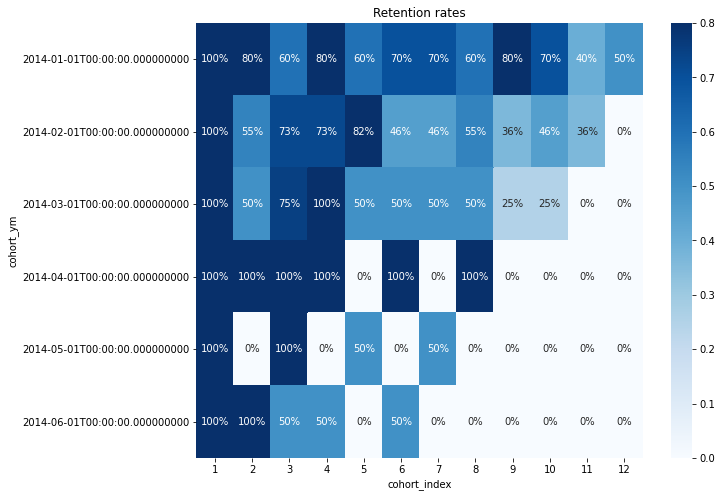

In [ ]:
plt.figure(figsize = (10,8))
plt.title('Retention rates')
sns.heatmap(data = retention,
            annot = True,
            fmt = '.0%',
            vmin = 0.0,
            vmax = 0.8,
            cmap = 'Blues')
plt.show()

#### Analyse customer RFM (Recency, Frequency, Monetary Value)

Create RFM Table

In [ ]:
# Create a table that shows, by customer their: Name, Days since last purchase (Recency),

# Get latest date
snapshot_date = max(cust_sales_tbl['order_date']) + dt.timedelta(days=1)

# Create a customer RFM matrix 

customer_RFM_tbl= cust_sales_tbl.groupby(['bikeshop_name']).agg({
    'order_date' : lambda x: (snapshot_date - x.max()).days,
    'order_line' : 'count',
    'sales_value' : 'sum'})

customer_RFM_tbl.rename( columns = {'order_date' : 'recency',
                                    'order_line' : 'frequency',
                                    'sales_value' : 'total_sales'}, inplace = True)
customer_RFM_tbl.head()

Create RFM segments 

In [ ]:
# Create quartiles to group RFM values into bins. 
# Generate labels for recency and asisgn to new column: R 
r_labels = range(4,0,-1)
r_quartiles = pd.qcut(customer_RFM_tbl['recency'],4,labels = r_labels)
customer_RFM_tbl = customer_RFM_tbl.assign(R = r_quartiles.values)

# Generate labels for frequency and asisgn to new column: F 
f_labels = range(1,5)
f_quartiles = pd.qcut(customer_RFM_tbl['frequency'],4,labels = f_labels)
customer_RFM_tbl = customer_RFM_tbl.assign(F = f_quartiles.values)

# Generate labels for frequency and asisgn to new column: F 
m_labels = range(1,5)
m_quartiles = pd.qcut(customer_RFM_tbl['total_sales'],4,labels = m_labels)
customer_RFM_tbl = customer_RFM_tbl.assign(M = m_quartiles.values)

# Create RFM Segments 

def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
customer_RFM_tbl['RFM_segment'] = customer_RFM_tbl.apply(join_rfm, axis =1)
customer_RFM_tbl['RFM_Score'] = customer_RFM_tbl[['R','F','M']].sum(axis=1)



Review RFM Segment statistics

In [ ]:
customer_RFM_tbl.groupby('RFM_Score').agg({
    'recency' : 'mean',
    'frequency' : 'mean',
    'total_sales' : ['mean','count']}).round(1)

recency frequency total_sales      
             mean      mean        mean count
RFM_Score                                    
3           204.5      14.0     82072.5     4
4            79.3      32.7    146673.3     3
5            89.8      35.8    156263.8     4
6           124.0      44.0    272440.0     1
7            36.0      47.0    215310.0     1
8            49.8      59.2    281285.8     6
9            25.0      98.0    388100.0     1
10           34.7      88.7    455866.7     3
11           33.7     127.7    547385.0     3
12           16.8     291.2   1299097.5     4

Group RFM scores into named segments

In [ ]:
def segment_me(df) : 
    if df['RFM_Score'] >= 9: 
        return 'Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Silver'
    else: 
        return 'Bronze'

customer_RFM_tbl['general_segment'] = customer_RFM_tbl.apply(segment_me,axis =1)

customer_RFM_tbl.groupby('general_segment').agg({
    'recency' : 'mean',
    'frequency' : 'mean',
    'total_sales' : ['mean','count']}).round(1)

recency frequency total_sales      
                   mean      mean        mean count
general_segment                                    
Bronze            150.9      22.0    109758.6     7
Gold               27.0     173.8    781295.0    11
Silver             68.2      49.1    233376.7    12

In [ ]:
customer_RFM_tbl.head()

,recency,frequency,total_sales,R,F,M,RFM_segment,RFM_Score,general_segment
bikeshop_name,,,,,,,,,
Albuquerque Cycles,294,16,81035,1,1,1,111,3,Bronze
Ann Arbor Speed,41,100,565625,3,3,4,334,10,Gold
Austin Cruisers,36,47,215310,3,2,2,322,7,Silver
Cincinnati Speed,124,44,272440,1,2,3,123,6,Silver
Columbus Race Equipment,103,61,324300,2,3,3,233,8,Silver


### Perform K means clustering